# Capstone Project Code

## Load Packages

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
import tensorflow as tf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, precision_score, f1_score, recall_score
warnings.filterwarnings("ignore")
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Initial Exploration
- Load Data
- Explore Data Pattern
- Explore Missing Values


### Explore Data Pattern

In [ ]:
def decompose_date_time(df):
  df['day'] = df['Date'].dt.day
  df['month'] = df['Date'].dt.month
  df['year'] = df['Date'].dt.year
  df['hour'] = df['Date'].dt.hour
  df['minute'] = df['Date'].dt.minute
  df['second'] = df['Date'].dt.second

In [ ]:
ABS_PATH = '/content/drive/MyDrive/'

def read_and_merge_data(data_type):
  '''
  read_and_merge_data('weather') returns a dictionary that maps
    location to the weather data with columns 'Date' and 'Data'

  read_and_merge_data('pressure_data') returns a dictionary that maps
    location to the pressure data with columns 'Date' and 'Data'
  '''
  path = ABS_PATH + data_type
  os.chdir(path)
  filenames = os.listdir()
  filenames.sort()
  data_ret = {}
  # collect data of the same lcoation
  for i in range(len(filenames)//3):
    curr_files = filenames[i*3:i*3+3]
    if data_type == "weather":
      curr_loc = curr_files[0].split('_')[1]
    else:
      curr_loc = curr_files[0].split('_')[0]

    dfs = []
    for file in curr_files:
      file_path = f"{path}/{file}"
      df = pd.read_hdf(file_path)
      df.reset_index(inplace = True)
      mapping = {df.columns[0]:'Date', df.columns[1]: 'Data'}
      df = df.rename(columns=mapping)
      decompose_date_time(df)
      dfs.append(df)
    data_ret[curr_loc] = pd.concat(dfs)
  return data_ret

In [ ]:
weather_data = read_and_merge_data("weather")
pressure_data = read_and_merge_data("pressure_data")

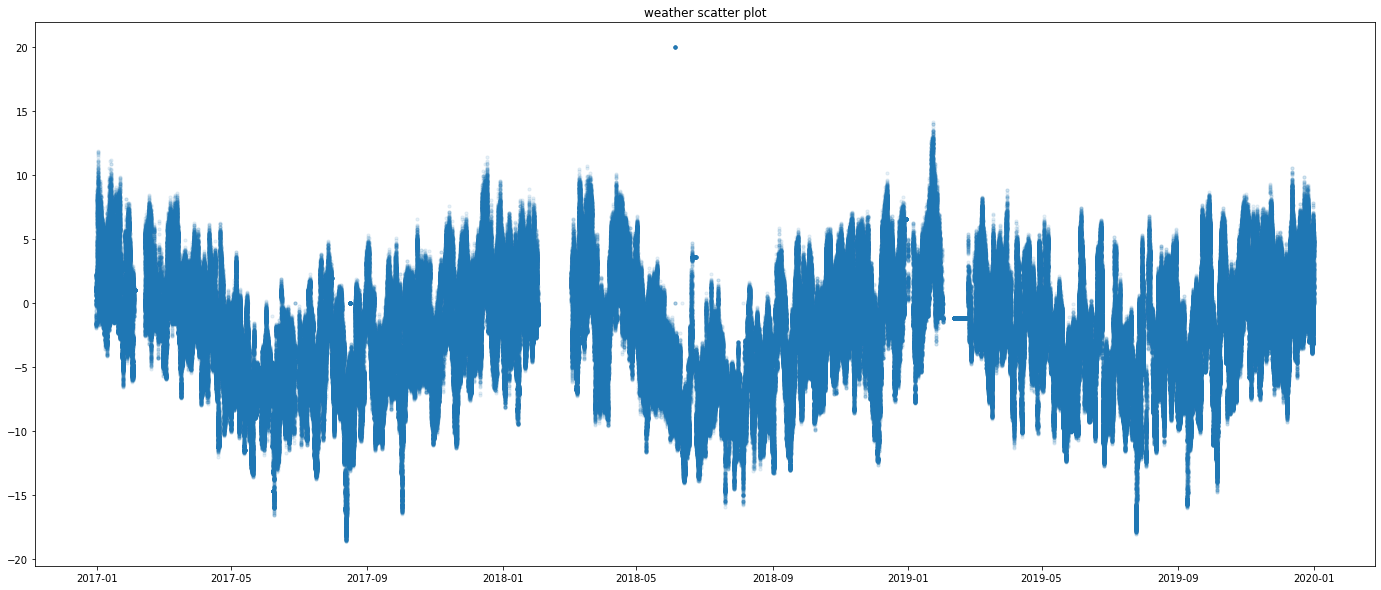

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(24,10))
plt.scatter(weather_data['MeteoCentral'].Date, weather_data['MeteoCentral'].Data, alpha=0.1, s=10);
plt.title('weather scatter plot');

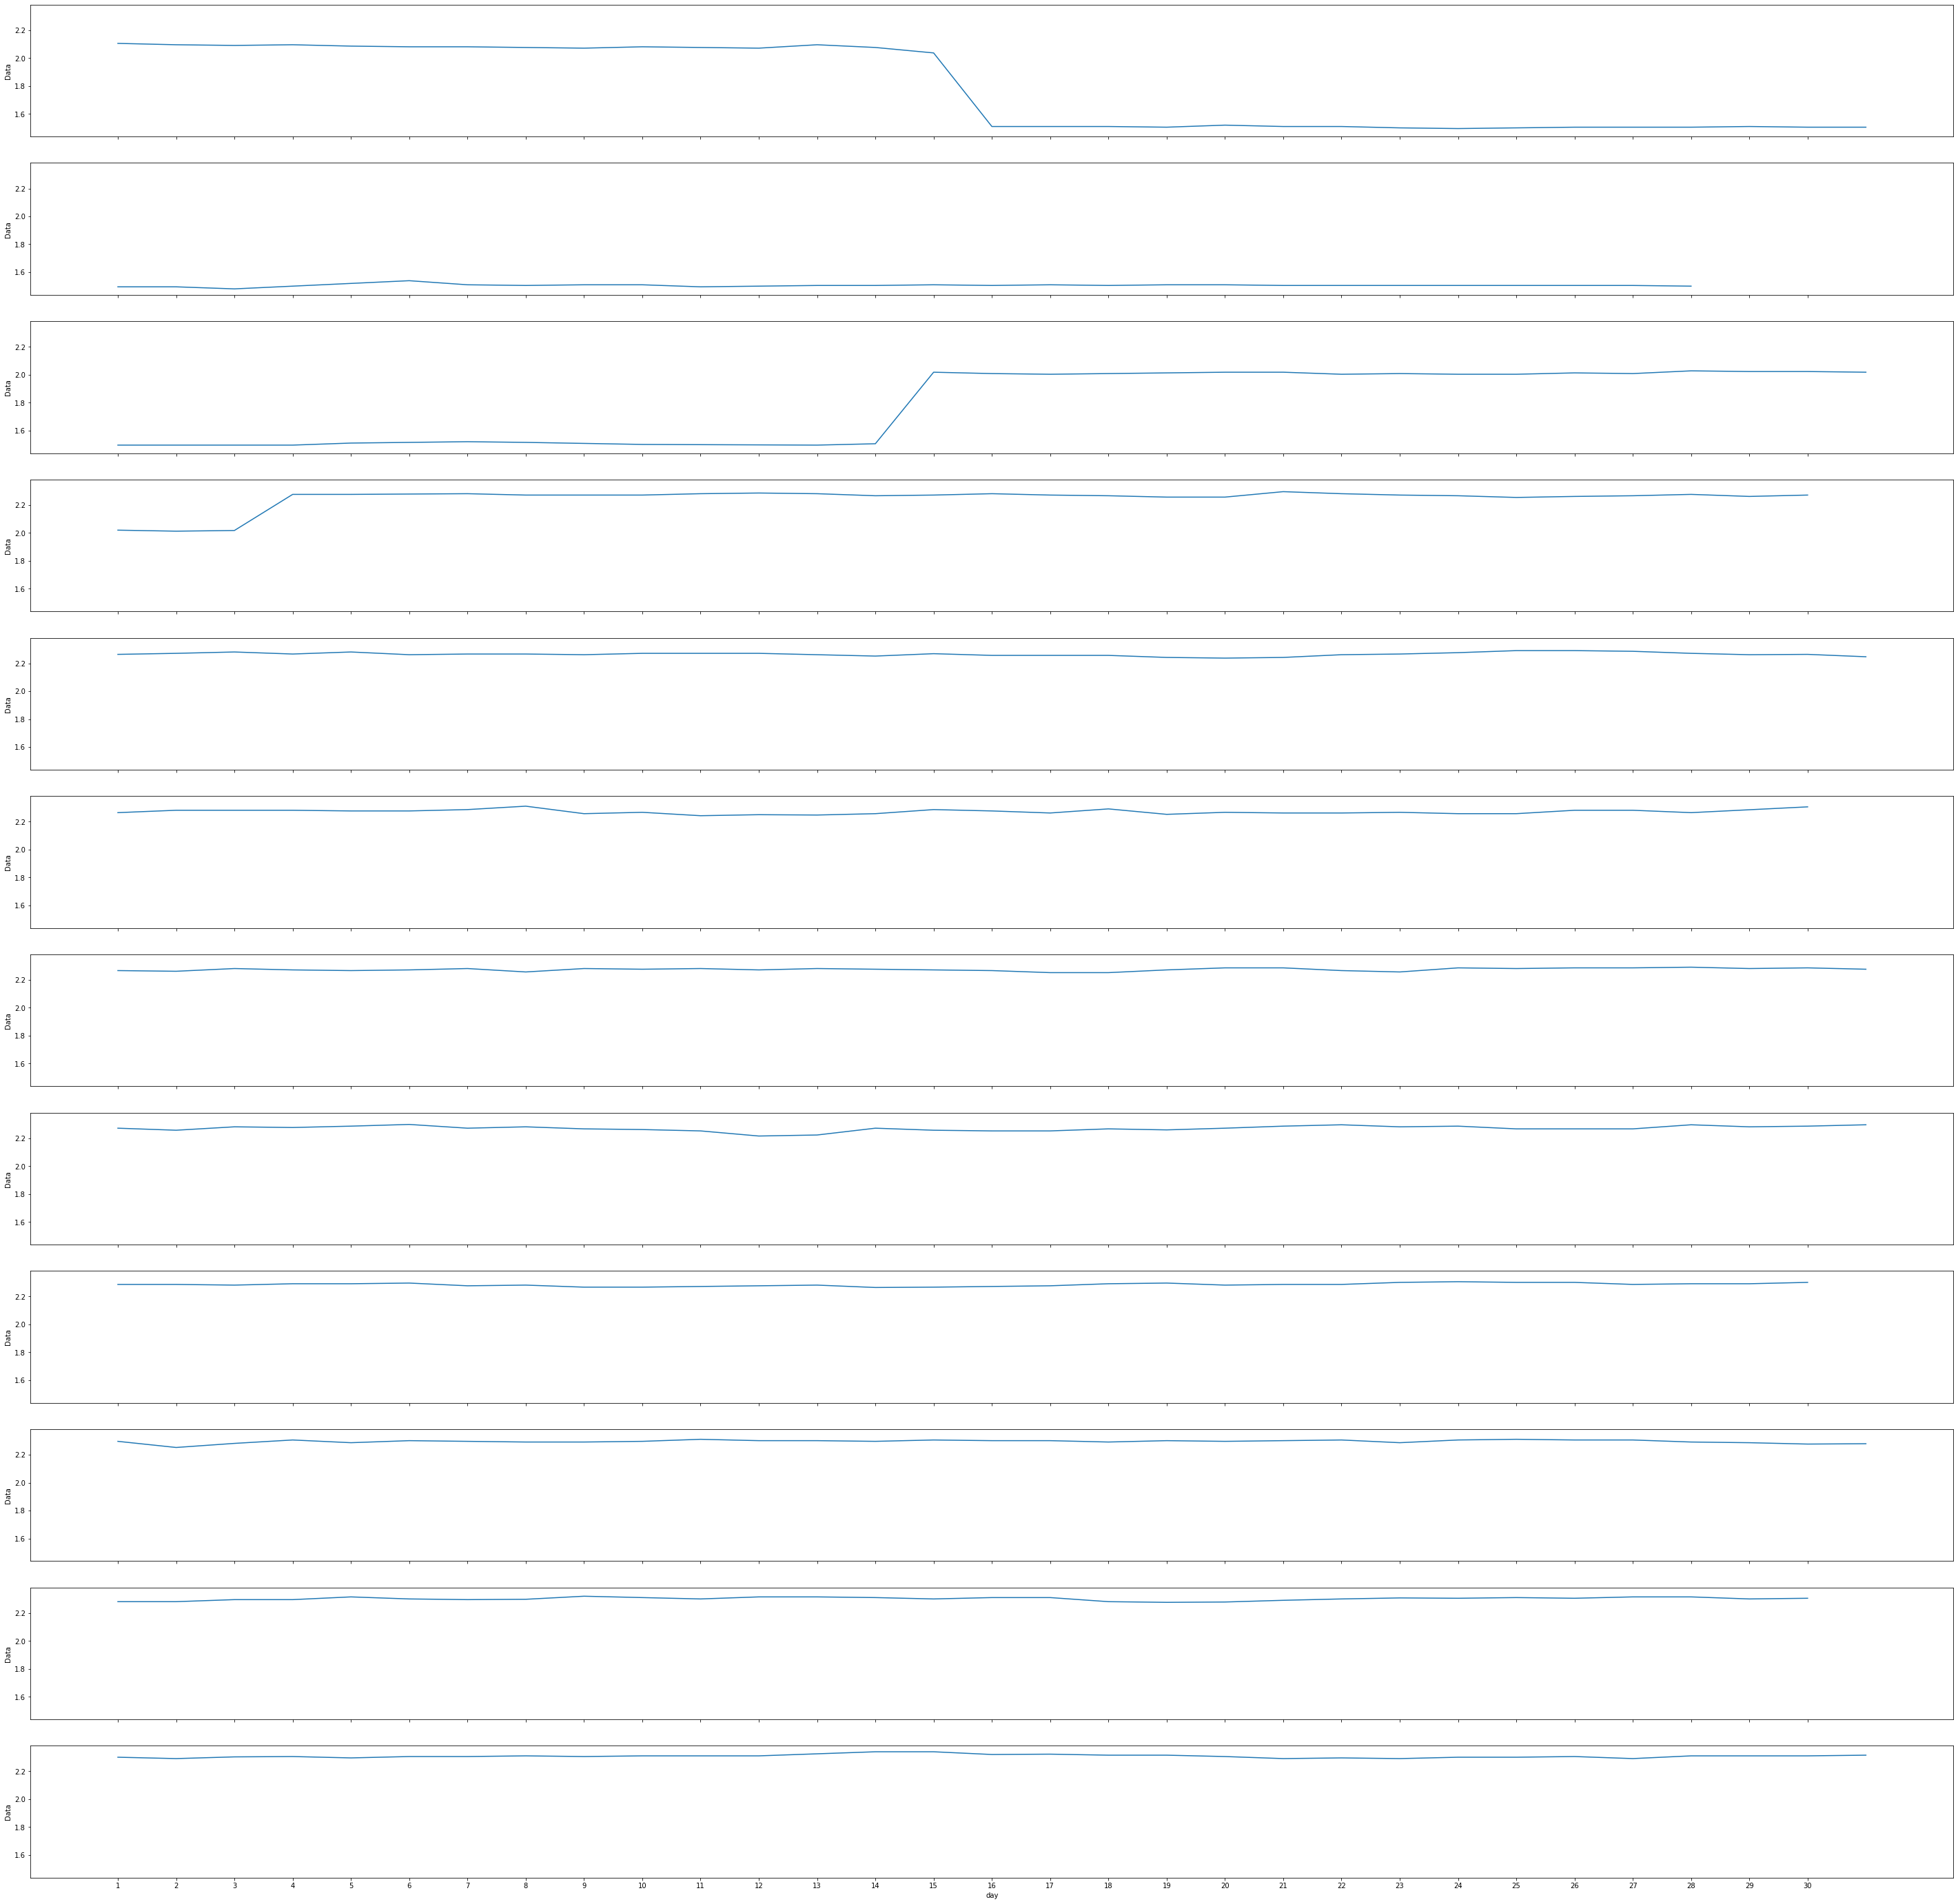

In [ ]:
def plot_day_data_in_year(df, year):
  year_data = df[df['year'] == year]
  fig, axes = plt.subplots(12, 1, figsize=(50, 50), sharex=True, sharey=True)
  for month in range(1, 13):
    month_data = year_data[year_data['month'] == month][['day', 'Data']]
    daily_min = month_data.groupby('day').min()
    daily_max = month_data.groupby('day').max()
    daily_median = month_data.groupby('day').median()
    daily_variance = month_data.groupby('day').var()
    plot = sns.lineplot(ax=axes[month-1], data=daily_median, x='day', y='Data')
    plot.set_xticks(range(1,len(daily_median))) # <--- set the ticks first
    
plot_day_data_in_year(pressure_data['A04'], 2017)

,r_squared,MSE
Jan,0.240338,0.062818
Feb,0.002029,0.000043
Mar,0.184225,0.051229
Apr,0.046542,0.005684
May,0.425070,0.000097
Jun,0.120507,0.000233
Jul,0.555552,0.000050
Aug,0.813099,0.000068
Sep,0.368083,0.000083
Oct,0.609615,0.000055


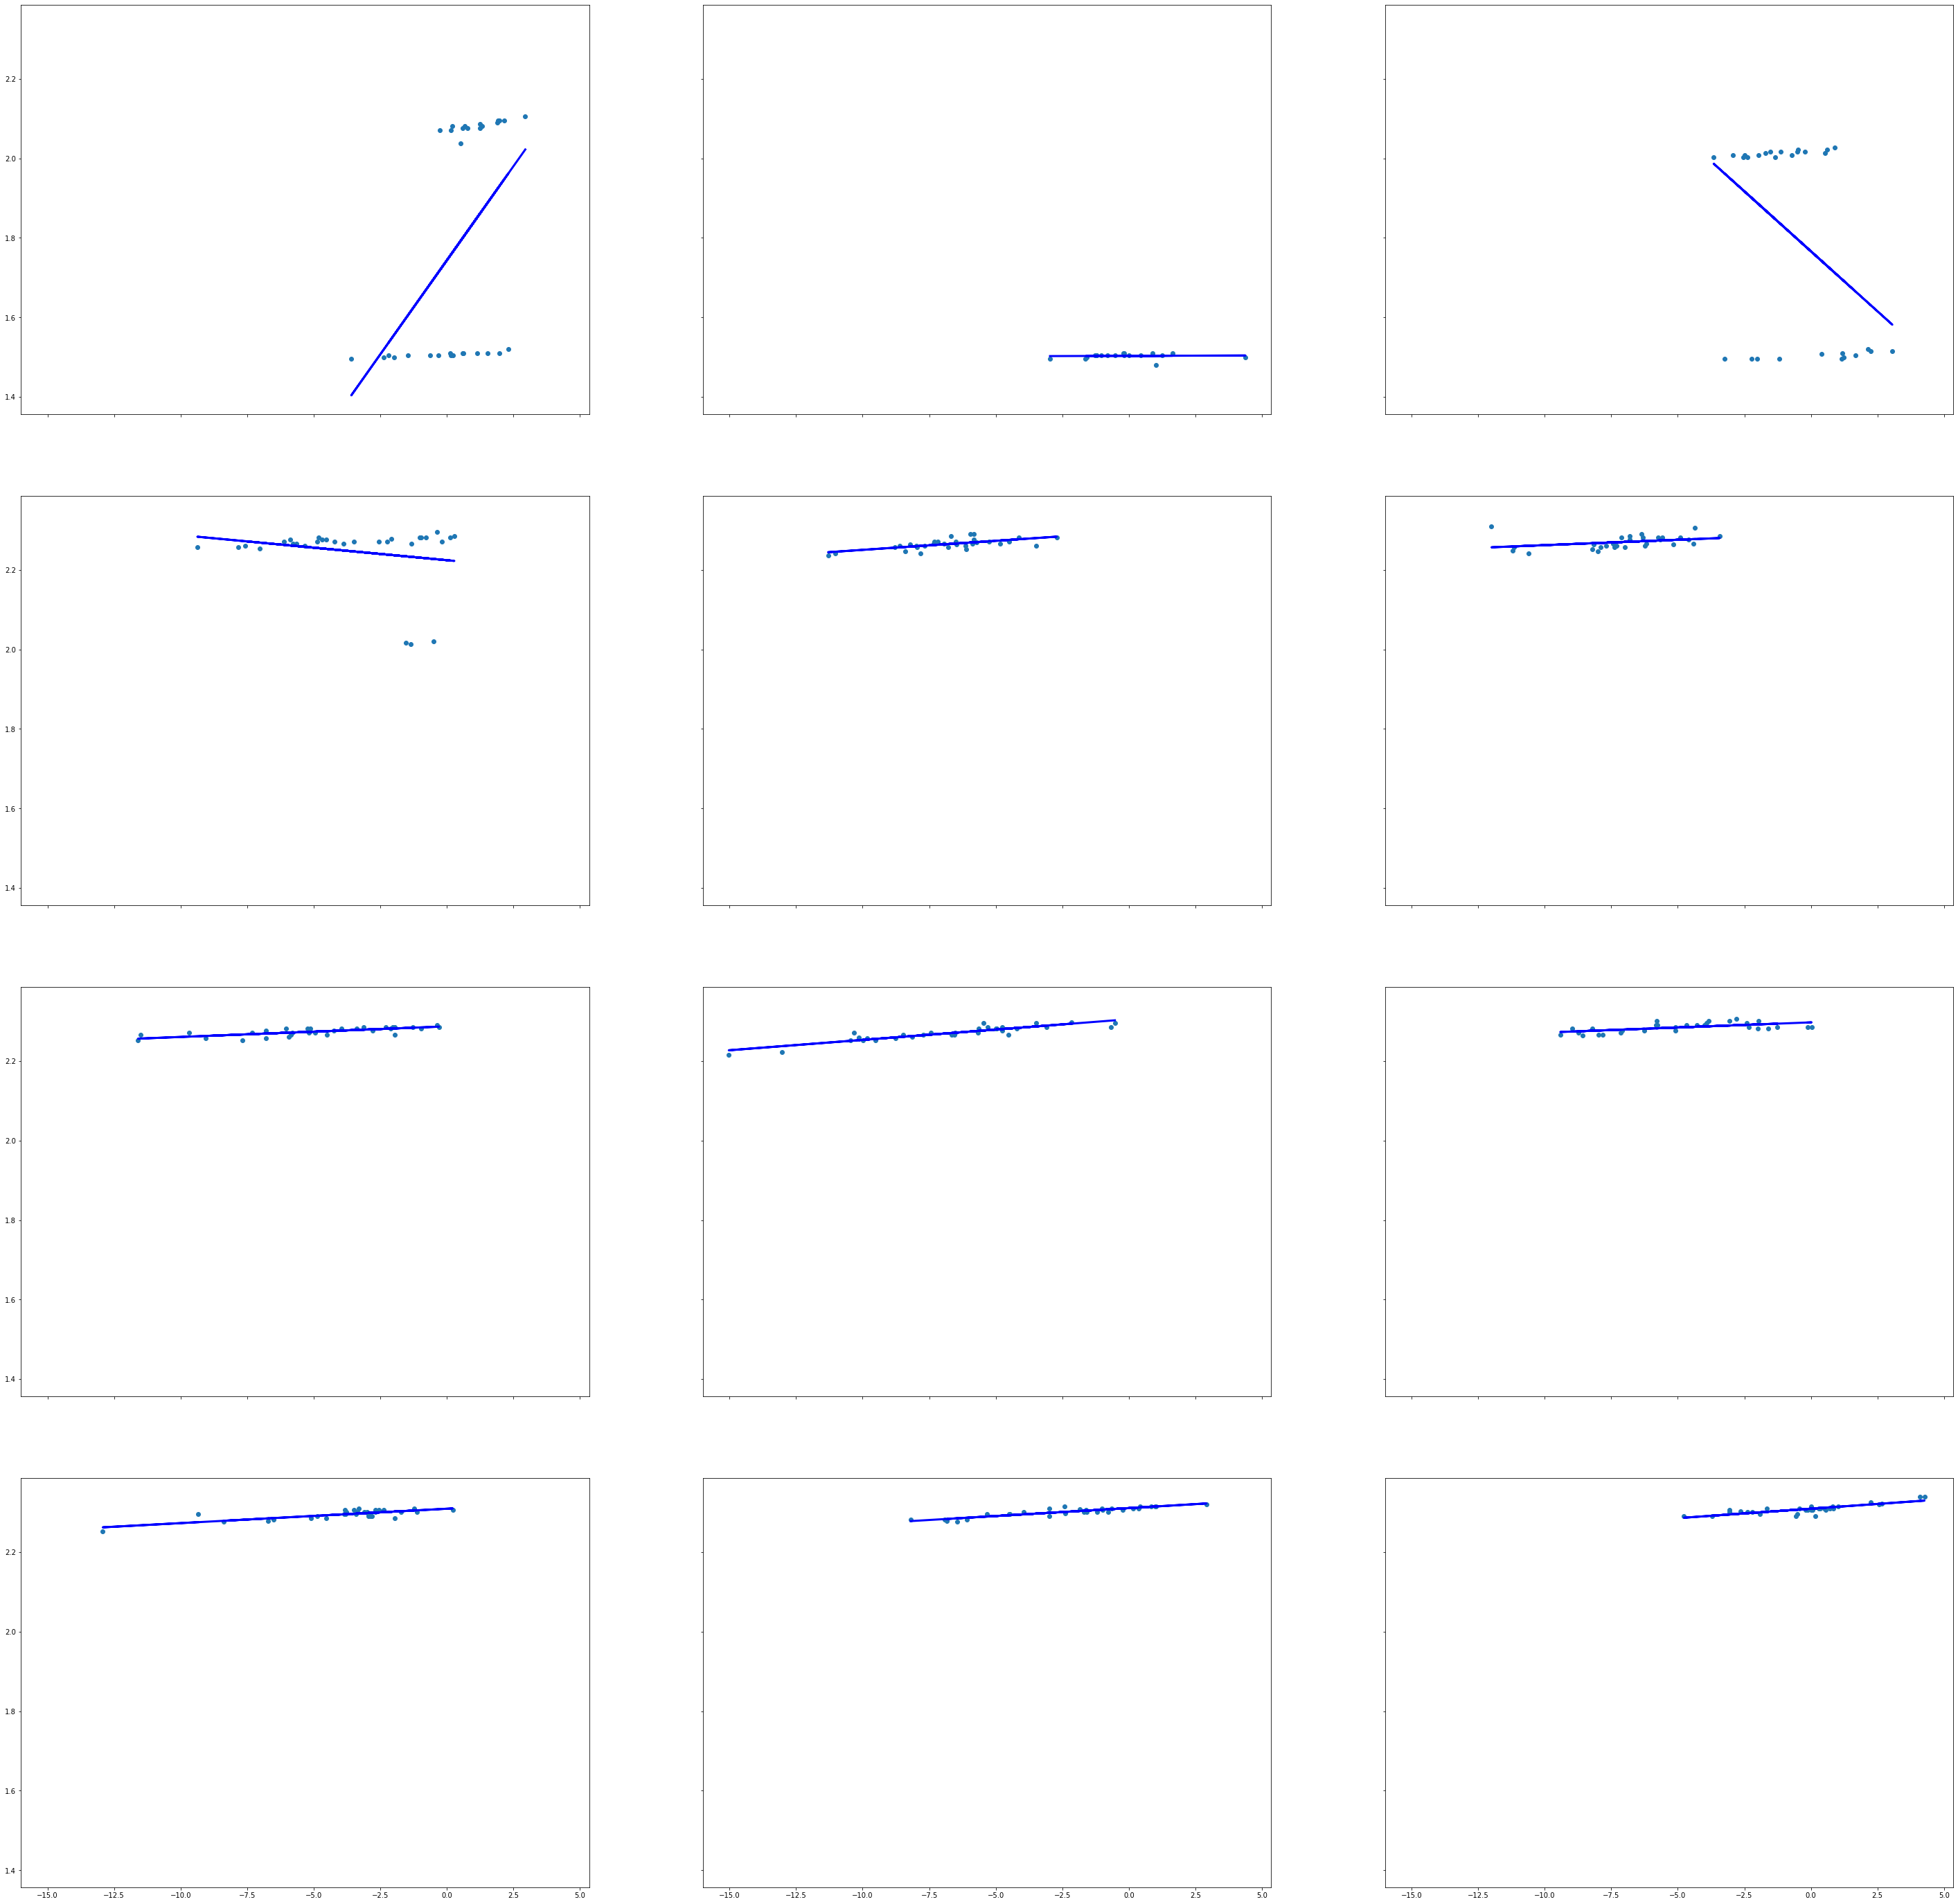

In [ ]:
def scatter_day_data_in_year(pressure, weather, year):
  pressure_year_data = pressure[pressure['year'] == year]
  weather_year_data = weather[weather['year'] == year]
  fig, axes = plt.subplots(4, 3, figsize=(50, 50), sharex=True, sharey=True)
  r_2 = []
  MSE = []
  for month in range(1, 13):
    pressure_month_data = pressure_year_data[pressure_year_data['month'] == month][['day', 'Data']]
    weather_month_data = weather_year_data[weather_year_data['month'] == month][['day', 'Data']]
    pressure_daily_median = pressure_month_data.groupby('day').median()
    weather_daily_median = weather_month_data.groupby('day').median()
    pressure_daily_median = pressure_daily_median.rename(columns={"Data":"pressure"})
    weather_daily_median = weather_daily_median.rename(columns={"Data":"weather"})
    median_table = pd.concat([weather_daily_median, pressure_daily_median], axis=1)
    median_table = median_table.dropna()
    
    regr = linear_model.LinearRegression()
    regr.fit(median_table['weather'].to_numpy().reshape(-1,1), median_table['pressure'].to_numpy().reshape(-1,1))
    pressure_pred = regr.predict(median_table['weather'].to_numpy().reshape(-1,1))

    r_2.append(r2_score(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))
    MSE.append(mean_squared_error(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))

    axes[(month-1)//3, (month-1)%3].scatter(data=median_table, x='weather', y='pressure')
    axes[(month-1)//3, (month-1)%3].plot(median_table['weather'], pressure_pred, color="blue", linewidth=3)

  metrics = pd.DataFrame(list(zip(r_2, MSE)),columns =['r_squared', 'MSE'], \
                         index =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
  return metrics

scatter_day_data_in_year(pressure_data['A04'], weather_data['MeteoCentral'], 2017)

In [ ]:
#scatter_day_data_in_year(pressure_data['A04'], weather_data['MeteoTB2'], 2017)

# Prophet Model

In [ ]:
from prophet import Prophet

In [ ]:
def change_columns(df):
  df['ds'] = df['Date']
  df['y'] = df['Data']
  return df

In [ ]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
  m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
              seasonality_mode = 'additive',
              interval_width = interval_width,
              changepoint_range = changepoint_range)
  m = m.fit(dataframe)
  forecast = m.predict(dataframe)
  forecast['fact'] = dataframe['Data'].reset_index(drop = True)
  return forecast

In [ ]:
def detect_anomalies(forecast):
  forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
  forecasted['anomaly'] = 0
  forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
  forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1
  #anomaly importances
  forecasted['importance'] = 0
  forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
    (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
  forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
    (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
  forecasted['anomaly'] = forecasted['anomaly'].astype('category')
  return forecasted
  

In [ ]:
def prophet_pipeline(location):
  df = change_columns(pressure_data[location])
  pred = fit_predict_model(df)
  return detect_anomalies(pred)

In [ ]:
def generate_result(name):
  pred = prophet_pipeline(name)
  sns.set_palette("bright")
  plt.figure(figsize=(8.33,6.77))
  plt.title("anomaly detection on pressure data %s" %(name,),fontsize=22)
  labels = {1:'Anamoly',0:'Normal'}
  p = sns.scatterplot(data=pred, x='ds', y = 'fact', hue=pred['anomaly'].map(labels),palette=['g','r'])
  plt.xlabel('Date',fontsize=20)
  plt.ylabel('Pressure',fontsize=20) 
  plt.legend(fontsize=18)
  plt.show(p)
  WINDOW_SIZE = 10
  pred['fault'] = pd.DataFrame(pred['anomaly'].rolling(window=WINDOW_SIZE).min() > 0)
  time = pred.loc[pred['fault']==True]['ds'].dt.strftime('%Y-%m-%d').unique()
  return time

In [ ]:
def get_accuracy(prophetRes,isolationForest):
  y_predict = [0]*1001
  y_true = [0]*1001
  for i in range(len(prophetRes)):
    if prophetRes[i] in isolationForest:
      y_predict[i] = 1
  for i in range(len(isolationForest)):
    y_true[i] = 1
  precision = precision_score(y_true,y_predict,average='weighted')
  f1 = f1_score(y_true,y_predict,average='weighted')
  recall = recall_score(y_true,y_predict,average='weighted')
  print(f'precision score is {precision}, f1 score is {f1}, recall score is {recall}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/zciszvhl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/e85u7k4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52525', 'data', 'file=/tmp/tmp12x5aupc/zciszvhl.json', 'init=/tmp/tmp12x5aupc/e85u7k4b.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_modelt3zxn0ot/prophet_model-20221215233842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


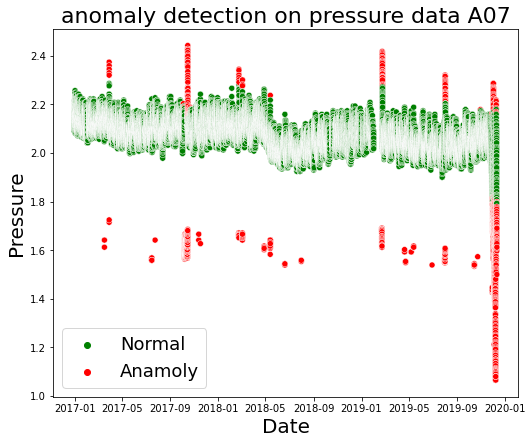

In [ ]:
A07 = generate_result('A07')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/3okx4mpz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/dmp7kwvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49342', 'data', 'file=/tmp/tmp12x5aupc/3okx4mpz.json', 'init=/tmp/tmp12x5aupc/dmp7kwvk.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_modelp1fs6jgp/prophet_model-20221215234158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:44:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


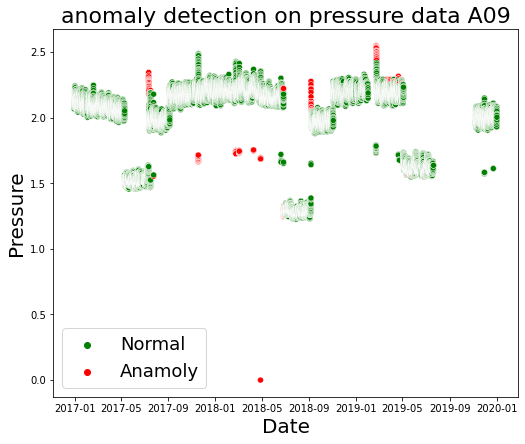

In [ ]:
A09 = generate_result('A09')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/uotc0lea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/aj5dn2af.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74956', 'data', 'file=/tmp/tmp12x5aupc/uotc0lea.json', 'init=/tmp/tmp12x5aupc/aj5dn2af.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_modelxmobd0rh/prophet_model-20221215234547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:45:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


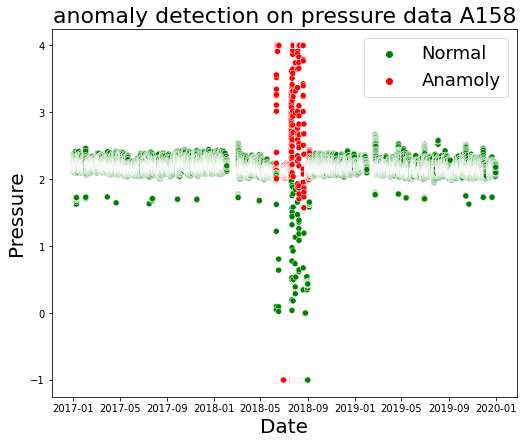

In [ ]:
A158 = generate_result('A158')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/n3s4e0kf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/15a4jnq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67714', 'data', 'file=/tmp/tmp12x5aupc/n3s4e0kf.json', 'init=/tmp/tmp12x5aupc/15a4jnq0.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_model8w_2j_i1/prophet_model-20221215235026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:50:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:52:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


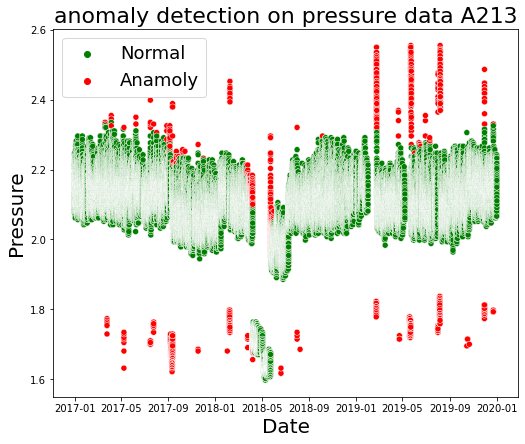

In [ ]:
A213 = generate_result('A213')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/mft1fkip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/u2dgm1k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77783', 'data', 'file=/tmp/tmp12x5aupc/mft1fkip.json', 'init=/tmp/tmp12x5aupc/u2dgm1k9.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_modelzk8gdmp3/prophet_model-20221215235421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


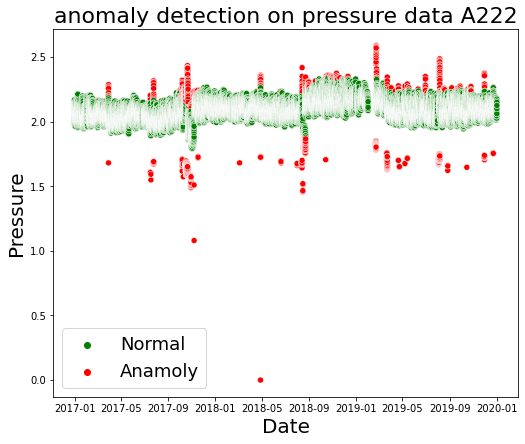

In [ ]:
A222 = generate_result('A222')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/yk91u_kz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12x5aupc/vuylwni6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83230', 'data', 'file=/tmp/tmp12x5aupc/yk91u_kz.json', 'init=/tmp/tmp12x5aupc/vuylwni6.json', 'output', 'file=/tmp/tmp12x5aupc/prophet_modelfjmvra0w/prophet_model-20221215235741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


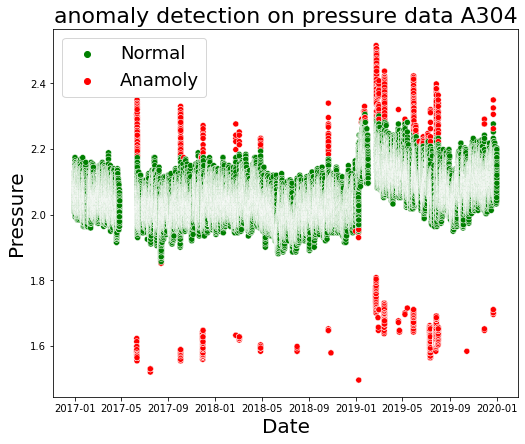

In [ ]:
A304 = generate_result('A304')

In [ ]:
isolationForest = ['2017-01-01', '2017-06-08', '2017-08-12', '2017-08-13', '2017-10-08', '2017-10-09', '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15', '2017-12-14', '2018-03-21', '2018-06-12', '2018-07-28', '2018-08-05', '2018-12-29', '2019-01-21', '2019-01-22', '2019-01-23', '2019-02-21', '2019-02-22', '2019-02-23', '2019-07-24', '2019-07-25', '2019-08-03', '2019-11-29', '2019-11-30', '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09', '2019-12-10', '2019-12-11']
get_accuracy(A07,isolationForest)

precision score is 0.9833121888336612, f1 score is 0.9808000720842391, recall score is 0.983016983016983


In [ ]:
isolationForest = ['2017-05-19', '2017-05-20', '2017-06-08', '2017-06-09', '2017-07-11', '2017-07-16', '2017-08-12', '2017-08-13', '2017-10-02', '2017-11-18', '2018-03-21', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-26', '2018-07-13', '2018-07-23', '2018-07-28', '2018-08-04', '2018-08-05', '2018-08-11', '2018-09-01', '2018-09-03', '2018-09-04', '2018-09-05', '2018-09-16', '2018-12-29', '2019-01-21', '2019-01-22', '2019-01-23', '2019-02-20', '2019-02-22', '2019-05-06', '2019-06-05', '2019-06-20', '2019-06-23', '2019-06-26']
get_accuracy(A09,isolationForest)

precision score is 0.9681241526778137, f1 score is 0.9540431335185132, recall score is 0.967032967032967


In [ ]:
isolationForest = ['2017-08-12', '2018-03-03', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-17', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-29', '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-28', '2018-07-30', '2018-08-04', '2018-08-05', '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11', '2018-08-17', '2018-08-18', '2018-08-19', '2018-08-24', '2018-08-25', '2018-08-29', '2018-08-30', '2018-08-31', '2018-12-29', '2019-01-21', '2019-01-22', '2019-01-23', '2019-02-21', '2019-02-23', '2019-07-25', '2019-08-04']
get_accuracy(A158,isolationForest)

precision score is 0.9510535523841562, f1 score is 0.9538645144220778, recall score is 0.9590409590409591


In [ ]:
isolationForest =['2017-06-08', '2017-08-12', '2017-08-13', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10', '2017-09-11', '2018-04-14', '2018-04-15', '2018-04-23', '2018-04-24', '2018-04-25', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-06', '2018-05-07', '2018-05-09', '2018-05-10', '2018-05-18', '2018-05-23', '2018-06-12', '2018-06-13', '2018-06-21', '2018-06-22', '2018-12-29', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-02-21', '2019-02-22', '2019-02-23', '2019-05-19', '2019-05-20', '2019-05-21', '2019-05-23', '2019-07-25', '2019-08-05', '2019-08-07']
get_accuracy(A213,isolationForest)

precision score is 0.9747108874897922, f1 score is 0.96816980552849, recall score is 0.974025974025974


In [ ]:
isolationForest =['2017-06-08', '2017-08-12', '2017-08-13', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10', '2017-09-11', '2018-04-14', '2018-04-15', '2018-04-23', '2018-04-24', '2018-04-25', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-06', '2018-05-07', '2018-05-09', '2018-05-10', '2018-05-18', '2018-05-23', '2018-06-12', '2018-06-13', '2018-06-21', '2018-06-22', '2018-12-29', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-02-21', '2019-02-22', '2019-02-23', '2019-05-19', '2019-05-20', '2019-05-21', '2019-05-23', '2019-07-25', '2019-08-05', '2019-08-07']
get_accuracy(A222,isolationForest)

precision score is 0.963483410377198, f1 score is 0.9460136390677759, recall score is 0.962037962037962


In [ ]:
isolationForest = ['2017-06-10', '2017-06-12', '2017-08-12', '2017-08-13', '2017-10-02', '2017-11-28', '2017-11-29', '2017-12-14', '2017-12-15', '2018-03-21', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-22', '2018-07-28', '2018-08-05', '2018-12-29', '2019-01-16', '2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-28', '2019-03-08', '2019-03-14', '2019-05-30', '2019-07-11', '2019-07-12', '2019-07-24', '2019-07-26', '2019-07-27', '2019-07-28', '2019-08-03']
get_accuracy(A304,isolationForest)

precision score is 0.9785138564385767, f1 score is 0.9739780937098944, recall score is 0.978021978021978


# Isolation Forest

In [ ]:
central_weather = weather_data['MeteoCentral']
central_weather.rename(columns = {'Data':'temp'}, inplace = True)
central_weather['datetime'] = central_weather['Date'].dt.date
weather_train = central_weather.groupby('datetime').mean()
weather_train = weather_train.reset_index()
weather_train

,datetime,temp,day,month,year,hour,minute,second
0,2016-12-31,2.227983,31.0,12.0,2016.0,9.784685,29.454054,24.536937
1,2017-01-01,4.333714,1.0,1.0,2017.0,11.577653,29.434294,29.025299
2,2017-01-02,2.777642,2.0,1.0,2017.0,11.302210,29.486814,34.642195
3,2017-01-03,3.138826,3.0,1.0,2017.0,11.407698,29.460442,36.492516
4,2017-01-04,3.110395,4.0,1.0,2017.0,10.991011,29.729588,39.281648
...,...,...,...,...,...,...,...,...
1037,2019-12-27,1.670668,27.0,12.0,2019.0,11.083895,29.314607,7.378277
1038,2019-12-28,-0.273344,28.0,12.0,2019.0,11.297065,29.292770,26.891911
1039,2019-12-29,0.263355,29.0,12.0,2019.0,11.501059,29.470007,32.739591
1040,2019-12-30,1.120457,30.0,12.0,2019.0,13.551257,29.722921,12.286750


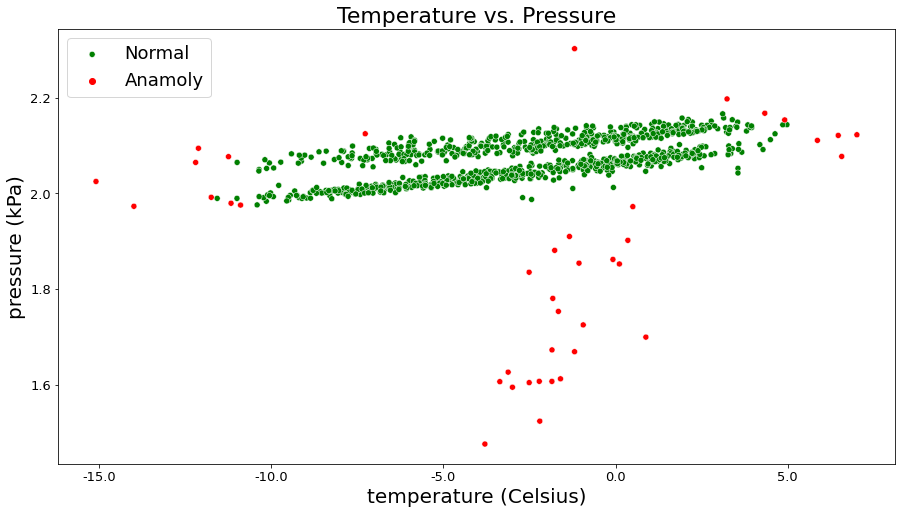

In [ ]:
df = pressure_data['A07']
df['datetime'] = df['Date'].dt.date
pressure_train = df.groupby('datetime').mean()
pressure_train.rename(columns = {'Data':'pressure'}, inplace = True)
pressure_train = pressure_train.reset_index()
merged_df = pd.merge(pressure_train, weather_train,  how='left', left_on=['datetime'], right_on = ['datetime'])
merged_df = merged_df.dropna()

train_data = merged_df[['pressure','temp']]
ifm = IsolationForest(contamination=0.04,n_estimators=100,max_samples=10000,random_state=99)
ifm.fit(train_data)
y_pred_train = ifm.predict(train_data)
train_data['outliers']=y_pred_train
sns.color_palette("bright")
plt.figure(figsize=(15,8))
dotplot = sns.scatterplot(data=train_data, x='temp', y = 'pressure', hue='outliers', palette=['r', 'g'])
plt.title('Temperature vs. Pressure',fontsize=22)
plt.xlabel('temperature (Celsius)',fontsize=20)
plt.ylabel('pressure (kPa)',fontsize=20)
plt.legend(loc='upper left', labels=['Normal', 'Anamoly'],fontsize=18)
dotplot.set_xticklabels([str(round(i,1)) for i in dotplot.get_xticks()], fontsize = 13)
dotplot.set_yticklabels([str(round(i,1)) for i in dotplot.get_yticks()], fontsize = 13)
plt.show(dotplot)

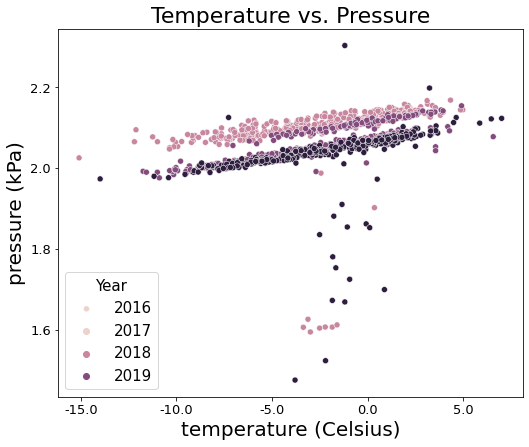

In [ ]:
plt.figure(figsize=(8.33,6.77))
merged_df['outliers']=y_pred_train
dotplot = sns.scatterplot(data=merged_df, x='temp', y = 'pressure', hue='year_x')
plt.title('Temperature vs. Pressure',fontsize=22)
plt.xlabel('temperature (Celsius)',fontsize=20)
plt.ylabel('pressure (kPa)',fontsize=20)
plt.legend(title = 'Year',loc='lower left', labels=['2016', '2017','2018','2019'],title_fontsize=15,fontsize=15)
dotplot.set_xticklabels([str(round(i,1)) for i in dotplot.get_xticks()], fontsize = 13)
dotplot.set_yticklabels([str(round(i,1)) for i in dotplot.get_yticks()], fontsize = 13)
plt.show(dotplot)

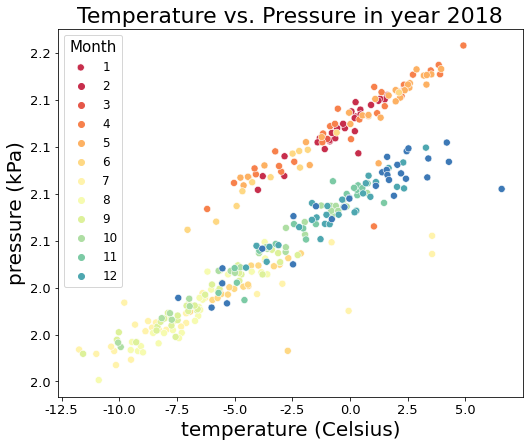

In [ ]:
df_18 = merged_df[merged_df['year_x']==2018]
sns.set_palette("RdBu")
plt.figure(figsize=(8.33,6.77))
dotplot = sns.scatterplot(data=df_18, x='temp', y = 'pressure',hue='month_x',palette=sns.color_palette('Spectral', n_colors=12),s=50)
plt.title('Temperature vs. Pressure in year 2018',fontsize=22)
plt.xlabel('temperature (Celsius)',fontsize=20)
plt.ylabel('pressure (kPa)',fontsize=20)
plt.legend(title = 'Month',loc='upper left', labels=['1', '2','3','4','5', '6','7','8','9', '10','11','12'],title_fontsize=15,fontsize=12)
dotplot.set_xticklabels([str(round(i,1)) for i in dotplot.get_xticks()], fontsize = 13)
dotplot.set_yticklabels([str(round(i,1)) for i in dotplot.get_yticks()], fontsize = 13)
plt.show(dotplot)

In [ ]:
from sklearn.ensemble import IsolationForest
def if_gen_result(aet):
  df = pressure_data[aet]
  df['datetime'] = df['Date'].dt.date
  pressure_train = df.groupby('datetime').mean()
  pressure_train.rename(columns = {'Data':'pressure'}, inplace = True)
  pressure_train = pressure_train.reset_index()
  merged_df = pd.merge(pressure_train, weather_train,  how='left', left_on=['datetime'], right_on = ['datetime'])
  merged_df = merged_df.dropna()

  train_data = merged_df[['pressure','temp']]
  ifm = IsolationForest(contamination=0.04,n_estimators=100,max_samples=10000,random_state=99)
  ifm.fit(train_data)
  y_pred_train = ifm.predict(train_data)
  merged_df['outliers']=y_pred_train

  sns.color_palette("bright")
  plt.figure(figsize=(8.33,6.77))
  train_data['outliers']=y_pred_train
  dotplot = sns.scatterplot(data=train_data, x='temp', y = 'pressure', hue='outliers', palette=['r', 'g'])
  plt.title('Temperature vs. Pressure '+str(aet),fontsize=22)
  plt.xlabel('temperature (Celsius)',fontsize=20)
  plt.ylabel('pressure (kPa)',fontsize=20)
  plt.legend(loc='upper left', labels=['Normal', 'Anamoly'],fontsize=18)
  dotplot.set_xticklabels([str(round(i,1)) for i in dotplot.get_xticks()], fontsize = 13)
  dotplot.set_yticklabels([str(round(i,1)) for i in dotplot.get_yticks()], fontsize = 13)
  plt.show(dotplot)

  return y_pred_train,merged_df['datetime']

In [ ]:
#hyperparameter tuning
true_label = ['17-10-07', '17-10-08', '17-10-09', '17-10-10', '17-10-11',
'17-10-12', '17-10-13', '17-10-14', '17-10-15', '17-10-16',
'18-02-22', '18-03-03', '18-04-28', '18-05-13', '19-02-21',
'19-02-22', '19-02-23', '19-08-01', '19-08-02', '19-11-29',
'19-12-01', '19-12-02', '19-12-03', '19-12-04', '19-12-05',
'19-12-06', '19-12-07', '19-12-08', '19-12-09', '19-12-10',
 '19-12-11']
true_abnormal = []
for i in true_label:
  temp = '20'+ i 
  true_abnormal.append(temp)
true_label = []
for i in merged_df['datetime']:
  if str(i) in true_abnormal:
    true_label.append(-1)
  else:
    true_label.append(1)

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
n_estimators = [100,200,400,800]
contamination = [0.03,0.04,0.05,0.08,0.1]
max_samples = [100,200,400,500,1000,2000]
pre_scores = []
f1_scores = []
recall_scores = []
for i in max_samples:
  train_data = merged_df[['pressure','temp']]
  ifm = IsolationForest(contamination=0.04,n_estimators=100,max_samples=10000,random_state=99)
  ifm.fit(train_data)
  y_pred_train_temp = ifm.predict(train_data)
  pre_scores.append(precision_score(y_pred_train_temp, true_label, average='weighted'))
  f1_scores.append(f1_score(y_pred_train_temp, true_label, average='weighted'))
  recall_scores.append(recall_score(true_label, y_pred_train_temp, average='weighted'))
print(pre_scores)
print(f1_scores)
print(recall_scores)

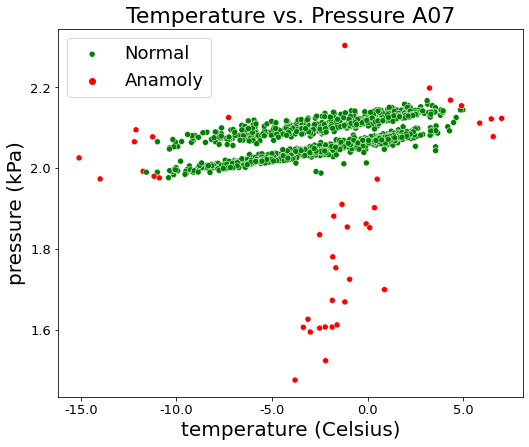

In [ ]:
a07_if,a07dates = if_gen_result('A07')

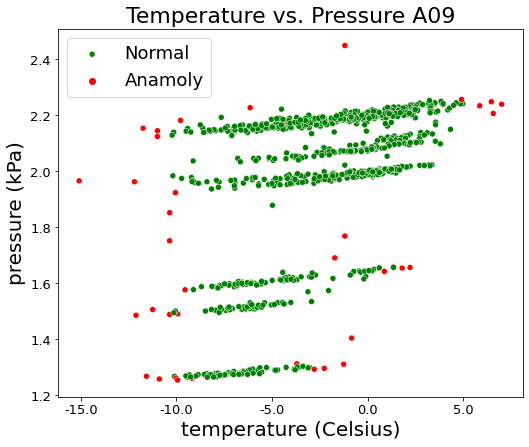

In [ ]:
a09_if,a09dates = if_gen_result('A09')

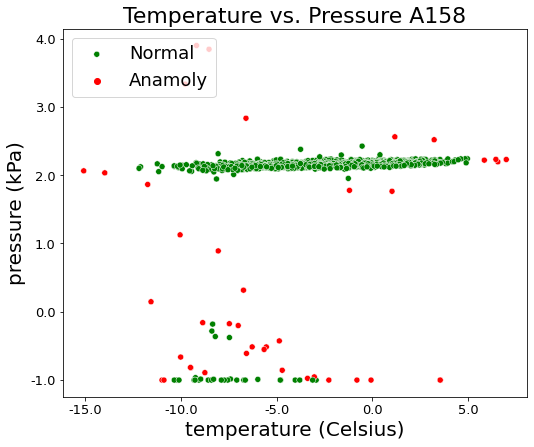

In [ ]:
a158_if,a158dates = if_gen_result('A158')

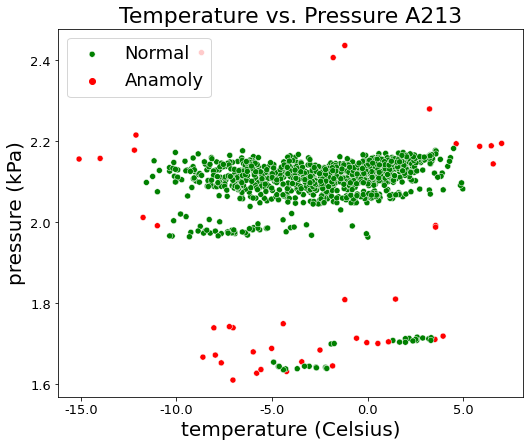

In [ ]:
a213_if,a213dates = if_gen_result('A213')

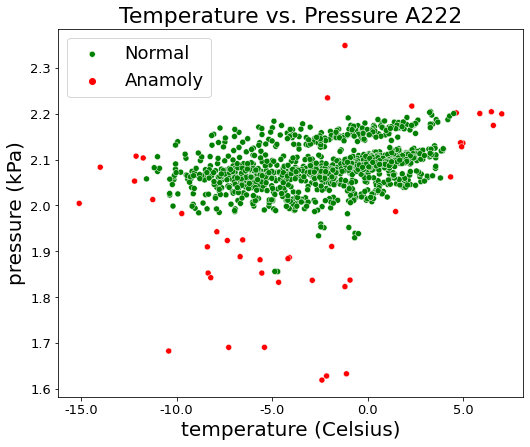

In [ ]:
a222_if,a222dates = if_gen_result('A222')

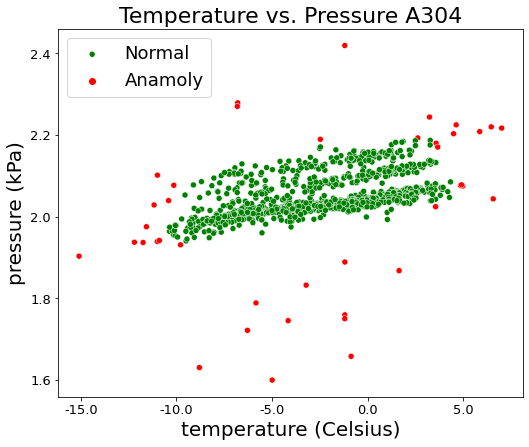

In [ ]:
a304_if,a304dates = if_gen_result('A304')

In [ ]:
def convert_input(string):
  temp = list(string.split(" "))
  res = []
  for i in temp:
    res.append(i[1:11])
  return res

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def calc_model_perf(true,pred,dates):
  true_dates = convert_input(true)
  true_label = []
  for i in dates:
    if str(i) in true:
      true_label.append(-1)
    else:
      true_label.append(1)
  precision = precision_score(pred, true_label, average='weighted')
  f1 =f1_score(pred, true_label, average='weighted')
  recall = recall_score(pred, true_label, average='weighted')
  print(f'precision score is {precision}, f1 score is {f1}, recall score is {recall}')

In [ ]:
prophet_09 = "'2017-07-11' '2017-07-12' '2017-11-17' '2018-02-22' '2018-03-03' '2018-04-28' '2018-06-26' '2018-06-27' '2018-06-28' '2018-06-29' '2018-06-30' '2018-07-01' '2018-07-02' '2018-09-05' '2018-09-06' '2019-02-21' '2019-02-22'"
calc_model_perf(prophet_09,a09_if,a09dates)

precision score is 0.9351485148514852, f1 score is 0.9419976690710933, recall score is 0.9513513513513514


In [ ]:
prophet_158 = "'2018-06-11' '2018-06-12' '2018-06-13' '2018-06-14' '2018-06-15' '2018-06-16' '2018-06-17' '2018-06-18' '2018-06-19' '2018-06-20' '2018-06-21' '2018-06-22' '2018-06-23' '2018-06-24' '2018-06-25' '2018-06-26' '2018-06-27' '2018-06-28' '2018-06-29' '2018-06-30' '2018-07-01' '2018-07-02' '2018-07-03' '2018-07-04' '2018-07-05' '2018-07-06' '2018-07-07' '2018-07-08' '2018-07-09' '2018-07-10''2018-07-11' '2018-07-12' '2018-07-13' '2018-07-14' '2018-07-15' '2018-07-16' '2018-07-17' '2018-07-18' '2018-07-19' '2018-07-20' '2018-07-21' '2018-07-22' '2018-07-23' '2018-07-24' '2018-07-25' '2018-07-26' '2018-07-27' '2018-07-28' '2018-07-29' '2018-07-30' '2018-07-31' '2018-08-01' '2018-08-02' '2018-08-03' '2018-08-04' '2018-08-05' '2018-08-06' '2018-08-07' '2018-08-08' '2018-08-09' '2018-08-10' '2018-08-11' '2018-08-12' '2018-08-13' '2018-08-14' '2018-08-15' '2018-08-31' '2018-09-01' '2018-09-02' '2018-09-03' '2018-09-04' '2018-09-05' '2018-09-06' '2018-09-07' '2018-09-08'"
calc_model_perf(prophet_158,a158_if,a158dates)

precision score is 0.9554446683080262, f1 score is 0.9425713120049555, recall score is 0.9333986287952988


In [ ]:
prophet_213 = "'2017-07-16' '2017-07-24' '2017-09-06' '2017-09-07' '2017-09-08' '2017-09-09' '2017-09-10' '2017-09-11' '2018-02-06' '2018-02-07' '2018-04-06' '2018-04-08' '2018-05-23' '2018-05-24' '2018-05-25' '2018-05-26' '2018-05-27' '2018-05-30' '2019-02-21' '2019-02-22' '2019-02-23' '2019-05-19' '2019-05-20' '2019-05-21' '2019-05-22' '2019-05-23' '2019-08-01' '2019-08-05' '2019-08-06' '2019-08-07' '2019-11-29'"
calc_model_perf(prophet_213,a213_if,a213dates)

precision score is 0.9558809801800665, f1 score is 0.9580016011442021, recall score is 0.9615004935834156


In [ ]:
prophet_222 = "'2017-07-24' '2017-10-06' '2017-10-09' '2017-10-12' '2017-10-13' '2017-10-14' '2017-10-15' '2017-10-16' '2017-10-17' '2017-10-18' '2017-10-19' '2017-10-20' '2017-10-21' '2017-10-28' '2017-10-29' '2017-11-06' '2017-11-11' '2018-04-28' '2018-08-13' '2018-08-15' '2018-08-16' '2018-08-17' '2018-08-18' '2018-08-19' '2018-08-20' '2018-08-21' '2018-08-22' '2018-08-30' '2019-02-20' '2019-02-21' '2019-02-22' '2019-03-21' '2019-03-22' '2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05' '2019-08-06' '2019-11-29'"
calc_model_perf(prophet_222,a222_if,a222dates)

precision score is 0.95490031292392, f1 score is 0.9556208391482639, recall score is 0.9563953488372093


In [ ]:
prophet_304 = "'2017-06-10' '2017-06-11' '2017-06-12' '2017-10-02' '2017-11-28' '2017-11-29' '2018-03-03' '2018-04-28' '2018-10-20' '2018-10-21' '2019-02-19' '2019-02-20' '2019-02-21' '2019-02-22' '2019-02-23' '2019-02-27' '2019-02-28' '2019-03-14' '2019-03-15' '2019-05-29' '2019-05-30' '2019-07-10' '2019-07-11' '2019-07-12' '2019-07-26' '2019-07-27' '2019-07-28' '2019-08-01'"
calc_model_perf(prophet_304,a304_if,a304dates)

precision score is 0.9645387381846114, f1 score is 0.9656863258692276, recall score is 0.9686234817813765
